In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#calculamos los parámetros de las galaxias 
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot

import matplotlib.pyplot as plt
import h5py
import rotation as rot
import barstrength as strng
import kapparot as krot

fo=open('/home/ornela/python/sem2/parametros.dat','w')
h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

vector = ('00','01','03','09','13','14','18','19','20','21')

snapshot=range(497,496,-1)
for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
    for i in range(0,3):
        cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value
        aexp = snap['subhalo_0'+ str('%s' %vector[i])+ '/Time'].value
        
        pstr = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
        masa_str = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s' %vector[i])+ '/Str/Velocities'].value
        
        pgas = snap['subhalo_0'+ str('%s' %vector[i])+ '/Gas/Coordinates'].value
        masa_gas = snap['subhalo_0'+ str('%s' %vector[i])+ '/Gas/Masses'].value
        
        pdrk = snap['subhalo_0'+ str('%s' %vector[i]) + '/Drk/Coordinates'].value
        masa_drk = snap['subhalo_0'+ str('%s' %vector[i])+ '/Drk/Masses'].value
        
        z = a0/aexp - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        
#---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp/h
        ystr = (pstr[:,1]-cm[1])*aexp/h
        zstr = (pstr[:,2]-cm[2])*aexp/h
        r = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xgas = (pgas[:,0]-cm[0])*aexp/h
        ygas = (pgas[:,1]-cm[1])*aexp/h
        zgas = (pgas[:,2]-cm[2])*aexp/h
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)
        
        xdrk = (pdrk[:,0]-cm[0])*aexp/h
        ydrk = (pdrk[:,1]-cm[1])*aexp/h
        zdrk = (pdrk[:,2]-cm[2])*aexp/h
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
         
        v_x = vel[:,0] *np.sqrt(aexp) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp) + Ht *zstr/1000.
        
#----------------------masas----------------------------
        masa_str = masa_str/h
        masa_gas = masa_gas/h
        masa_drk = masa_drk/h
        
        r200 = r200*aexp/h
        
        rgal=0.15*r200
        
        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])
        
        limit_gas = np.where(rgas<rgal)
        rgas_sort = np.sort(rgas[limit_gas])
        rgas_indice = np.argsort(rgas[limit_gas])
        
        Mc_str = cumsum((masa_str[limit])[r_indice])
        M_gal = Mc_str[-1]
        
        Mc_gas = cumsum((masa_gas[limit_gas])[rgas_indice])
        M_gas = Mc_gas[-1]
        
#------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)
        
        r90 = r_sort[noventa]
        r50 = r_sort[cincuenta]
        M90 = Mc_str[noventa]                
             
#------------------masa total en r200 (Mvir)--------------------------
        rvir= concatenate([r,rgas,rdrk])
        mvir= concatenate([masa_str, masa_gas, masa_drk])
        
        limit_vir = np.where(rvir<r200)
        rvir_sort = np.sort(rvir[limit_vir])
        rvir_indice = np.argsort(rvir[limit_vir])
        
        Mc_vir = cumsum((mvir[limit_vir])[rvir_indice])
        
        M_vir = Mc_vir[-1]

#-------------------------------------------------------------------            
        corte1,=np.where(r<r90[-1])
        corte2,=np.where(r<2*r50[-1])
        veloc,=np.where(r<r50[-1])
        
#----------componentes de la velocidad del centro de masa------------
        vxcm = sum(masa_str[veloc]*v_x[veloc])/sum(masa_str[veloc])
        vycm = sum(masa_str[veloc]*v_y[veloc])/sum(masa_str[veloc])
        vzcm = sum(masa_str[veloc]*v_z[veloc])/sum(masa_str[veloc])
        
#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = vel[:,0] - vxcm
        vy = vel[:,1] - vycm
        vz = vel[:,2] - vzcm
        
        xn, yn, zn, vxn, vyn, vzn = rot.rot(masa_str, xstr, ystr, zstr, vx, vy, vz, r90[-1])
        
        A2max, rmax = strng.a2max(masa_str[corte2], xn[corte2], yn[corte2], 20)
        
        k_rot = krot.kapa(masa_str[corte1], xn[corte1], yn[corte1], zn[corte1],
                         vxn[corte1], vyn[corte1], vzn[corte1])
                       
        fo.write(#str('%s'% name)+'\t'+
            str('%12.6f'% r50[-1])+'\t'+
            str('%12.6f'% r90[-1])+'\t'+
            str('%12.6f'% rgal)+'\t'+
            str('%12.6f'% np.log10(M90[-1]*1e10))+'\t'+
            str('%12.6f'% np.log10(M_gal*1e10))+'\t'+
            str('%12.6f'% np.log10(M_gas*1e10))+'\t'+
            str('%12.6f'% np.log10(M_vir*1e10))+'\t'+
            str('%12.6f'% A2max)+'\t'+
            str('%12.6f'% rmax)+'\t'+
            str('%12.6f'% k_rot)+'\n')
        fo.flush()



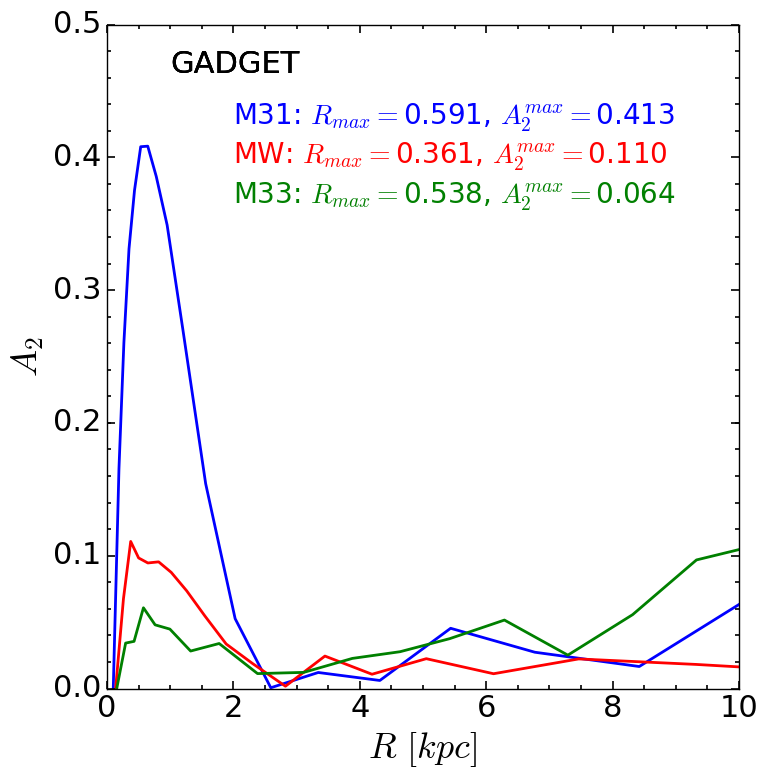

In [21]:
#graficamos A2 vs R

import matplotlib.pyplot as plt
import h5py
import rotation as rot
import barstrength as strng
import kapparot as krot

fo=open('/home/ornela/python/sem2/parametros.dat','w')
h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

vector = ('00','01','03')
vector3 = ('M31','MW','M33')
vector2= ('blue', 'red', 'green')

j=0
snapshot=range(497,496,-1)
for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
    for i in range(0,3):
        cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value
        aexp = snap['subhalo_0'+ str('%s' %vector[i])+ '/Time'].value
        
        pstr = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
        masa_str = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s' %vector[i])+ '/Str/Velocities'].value
        
        pgas = snap['subhalo_0'+ str('%s' %vector[i])+ '/Gas/Coordinates'].value
        masa_gas = snap['subhalo_0'+ str('%s' %vector[i])+ '/Gas/Masses'].value
        
        pdrk = snap['subhalo_0'+ str('%s' %vector[i]) + '/Drk/Coordinates'].value
        masa_drk = snap['subhalo_0'+ str('%s' %vector[i])+ '/Drk/Masses'].value
        
        z = a0/aexp - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        
#---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp/h
        ystr = (pstr[:,1]-cm[1])*aexp/h
        zstr = (pstr[:,2]-cm[2])*aexp/h
        r = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xgas = (pgas[:,0]-cm[0])*aexp/h
        ygas = (pgas[:,1]-cm[1])*aexp/h
        zgas = (pgas[:,2]-cm[2])*aexp/h
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)
        
        xdrk = (pdrk[:,0]-cm[0])*aexp/h
        ydrk = (pdrk[:,1]-cm[1])*aexp/h
        zdrk = (pdrk[:,2]-cm[2])*aexp/h
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
         
        v_x = vel[:,0] *np.sqrt(aexp) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp) + Ht *zstr/1000.
        
#----------------------masas----------------------------
        masa_str = masa_str/h
        masa_gas = masa_gas/h
        masa_drk = masa_drk/h
        
        r200 = r200*aexp/h
        
        rgal=0.15*r200
        
        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])
        
        limit_gas = np.where(rgas<rgal)
        rgas_sort = np.sort(rgas[limit_gas])
        rgas_indice = np.argsort(rgas[limit_gas])
        
        Mc_str = cumsum((masa_str[limit])[r_indice])
        M_gal = Mc_str[-1]
        
        Mc_gas = cumsum((masa_gas[limit_gas])[rgas_indice])
        M_gas = Mc_gas[-1]
        
#------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)
        
        r90 = r_sort[noventa]
        r50 = r_sort[cincuenta]
        M90 = Mc_str[noventa]                
             
#------------------masa total en r200 (Mvir)--------------------------
        rvir= concatenate([r,rgas,rdrk])
        mvir= concatenate([masa_str, masa_gas, masa_drk])
        
        limit_vir = np.where(rvir<r200)
        rvir_sort = np.sort(rvir[limit_vir])
        rvir_indice = np.argsort(rvir[limit_vir])
        
        Mc_vir = cumsum((mvir[limit_vir])[rvir_indice])
        
        M_vir = Mc_vir[-1]

#-------------------------------------------------------------------            
        corte1,=np.where(r<rgal)
        corte2,=np.where(r<2*r50[-1])
        veloc,=np.where(r<r50[-1])
        
#----------componentes de la velocidad del centro de masa------------
        vxcm = sum(masa_str[veloc]*v_x[veloc])/sum(masa_str[veloc])
        vycm = sum(masa_str[veloc]*v_y[veloc])/sum(masa_str[veloc])
        vzcm = sum(masa_str[veloc]*v_z[veloc])/sum(masa_str[veloc])
        
#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = vel[:,0] - vxcm
        vy = vel[:,1] - vycm
        vz = vel[:,2] - vzcm
        
        xn, yn, zn, vxn, vyn, vzn = rot.rot(masa_str, xstr, ystr, zstr, vx, vy, vz, r90[-1])
        
        A2max, rmax = strng.a2max(masa_str[corte2], xn[corte2], yn[corte2], 20)
        
        A2, phi, rbin = strng.a2(masa_str[corte1], xn[corte1], yn[corte1], 20)
        
        fig = plt.figure(1,figsize=(8,8))
        fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
        ax0=fig.add_subplot(111)
        ax0.plot(rbin,A2,'k', lw=2, color = '%s'%vector2[i])
        ax0.set_ylim(0,0.5)
        ax0.set_xlim(0,10)
        #ax0.set_title('subhalo_0'+ str('%s'%vector[i]), fontsize=24)
        ax0.set_xlabel(u'$R$ $[kpc]$', fontsize=26)
        ax0.set_ylabel(u'$A_2$', fontsize=26)
        ax0.minorticks_on()
        ax0.tick_params( labelsize=22)
        ax0.tick_params('both', length=3, width=1.2,which='minor')
        ax0.tick_params('both', length=6, width=1.2,which='major')
        plt.text(1,0.47,'GADGET', color='k',fontsize=22, ha='left', va='center')
        plt.text(x = 2, y = 0.43-(0.03*j), 
                 s =str('%s'%vector3[i])+': '+ '$R_{max}=$' +str('%.3f'%rmax)+', $A_{2}^{max}=$' + str('%.3f'%A2max),
                 fontsize = 20, va= 'center', ha= 'left', color = '%s'%vector2[i])
        j+=1
fig.savefig('/home/ornela/Escritorio/mi_tesis/Figures/GD_A2_r.png', dpi = 100)
        
#fig.savefig('r_vs_A2.png', dpi = 80)
plt.show()

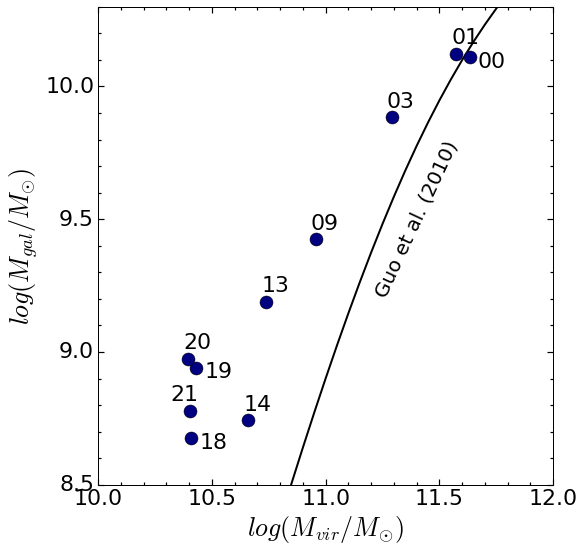

In [2]:
# Graficamos Mvir vs Mgal
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot
import matplotlib.pyplot as plt

cm=np.loadtxt('/home/ornela/python/parametros.dat')

Mgal =cm[:,4]
Mvir =cm[:,6]
M90 =cm[:,3]
  
c = 0.129
M0 = 10**11.4
alpha = 0.926
beta = 0.261
gamma = 2.440
MM = arange (10.5,12,0.05)
M_vir = 10**MM

vector = ('00','01','03','09','13','14','18','19','20','21')

#------------------curva de Guo et al 2010-------------------
c1 = (M_vir/M0)**(-alpha)
c2 = (M_vir/M0)**beta
M_estrella = M_vir * c * ((c1+c2)**(-gamma))

Me=log10(M_estrella)
   
#---------------------------------------------------------
fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax1=fig.add_subplot(111)
ax1.plot(MM,Me,'k', lw=2)
ax1.plot(Mvir,Mgal,'o', markersize=13, color='navy')
#ax1.plot(Mvir,M90,'^', markersize=10, color='b')
ax1.set_ylim(8.5,10.3)
ax1.set_xlim(10,12)
ax1.minorticks_on()
ax1.tick_params( labelsize=22)
ax1.tick_params('both', length=3, width=1.2,which='minor')
ax1.tick_params('both', length=6, width=1.2,which='major')  
ax1.set_xlabel(u'$log(M_{vir}/M_{\odot})$', fontsize=26)
ax1.set_ylabel(u'$log(M_{gal}/M_{\odot})$', fontsize=26)
plt.text(x = 11.4, y = 9.5, s = u'Guo et al. (2010)', fontsize = 20, rotation= 65,
         verticalalignment = 'center', horizontalalignment = 'center')
for i in range(0,10):
    if vector[i] == '00':
        plt.annotate(str('%s'%vector[i]), xy=(Mvir[i],Mgal[i]), 
                     xytext=(+8, -10), textcoords='offset points', fontsize=22)
    elif vector[i] == '18':
        plt.annotate(str('%s'%vector[i]), xy=(Mvir[i],Mgal[i]), 
                     xytext=(+8, -10), textcoords='offset points', fontsize=22)
    elif vector[i] == '19':
        plt.annotate(str('%s'%vector[i]), xy=(Mvir[i],Mgal[i]), 
                     xytext=(+8, -10), textcoords='offset points', fontsize=22)
    elif vector[i] == '21':
        plt.annotate(str('%s'%vector[i]), xy=(Mvir[i],Mgal[i]), 
                     xytext=(-20, +10), textcoords='offset points', fontsize=22)
    else:
        plt.annotate(str('%s'%vector[i]), xy=(Mvir[i],Mgal[i]), 
                     xytext=(-5, +10), textcoords='offset points', fontsize=22)

fig.savefig('Mvir_vs_Mgal.png', dpi = 80)
plt.show()
    

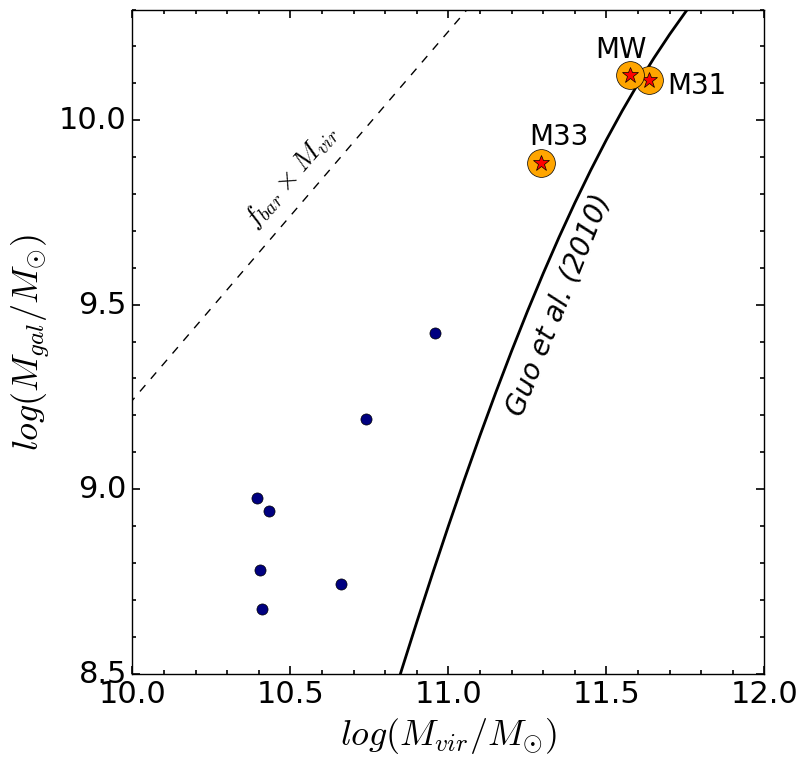

In [2]:
# Graficamos Mvir vs Mgal ##MODIFICADO
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot
import matplotlib.pyplot as plt

cm=np.loadtxt('/home/ornela/python/parametros.dat')

Mgal =cm[:,4]
Mvir =cm[:,6]
M90 =cm[:,3]
Mgas =cm[:,5]
  
c = 0.129
M0 = 10**11.4
alpha = 0.926
beta = 0.261
gamma = 2.440
MM = arange (10.5,12,0.05)
M_vir = 10**MM

vector = ('00','01','03','09','13','14','18','19','20','21')

#------------------curva de Guo et al 2010-------------------
c1 = (M_vir/M0)**(-alpha)
c2 = (M_vir/M0)**beta
M_estrella = M_vir * c * ((c1+c2)**(-gamma))

Me=log10(M_estrella)

#-------fraccion de bariones universal--------------------
MM1 = arange (9.5, 12, 0.05)
fbar = 0.0418/0.24
Mbar = fbar * 10**MM1

#---------------------------------------------------------
fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax1=fig.add_subplot(111)
ax1.plot(MM,Me,'k', lw=2)
ax1.plot(MM1,log10(Mbar),'--', lw=1, color ='k')
ax1.set_ylim(8.5,10.3)
ax1.set_xlim(10,12)
ax1.minorticks_on()
ax1.tick_params( labelsize=22)
ax1.tick_params('both', length=3, width=1.2,which='minor')
ax1.tick_params('both', length=6, width=1.2,which='major')  
ax1.set_xlabel(r'$log(M_{vir}/M_{\odot})$', fontsize=26)
ax1.set_ylabel(r'$log(M_{gal}/M_{\odot})$', fontsize=26)
plt.text(x = 11.35, y = 9.5, s = u'Guo et al. (2010)', fontsize = 20, rotation= 68,  style='italic',
         verticalalignment = 'center', horizontalalignment = 'center')
plt.text(x = 10.5, y = 9.85, s = r'$f_{bar}\times M_{vir}$', fontsize = 20, rotation= 49,
         verticalalignment = 'center', horizontalalignment = 'center')


for i in range(0,10):
    if vector[i] == '01':
        ax1.plot(Mvir[i],Mgal[i],'o', markersize=20, color='orange')
        ax1.plot(Mvir[i],Mgal[i],'*', markersize=12, color='r')
        plt.annotate('MW', xy=(Mvir[i],Mgal[i]), 
                     xytext=(-25, +13), textcoords='offset points', fontsize=20)
    elif vector[i] == '00':
        ax1.plot(Mvir[i],Mgal[i],'o', markersize=20, color='orange')
        ax1.plot(Mvir[i],Mgal[i],'*', markersize=12, color='r')
        plt.annotate('M31', xy=(Mvir[i],Mgal[i]), 
                     xytext=(+13, -10), textcoords='offset points', fontsize=20)
    elif vector[i] == '03':
        ax1.plot(Mvir[i],Mgal[i],'o', markersize=20, color='orange')
        ax1.plot(Mvir[i],Mgal[i],'*', markersize=12, color='r')
        plt.annotate('M33', xy=(Mvir[i],Mgal[i]), 
                     xytext=(-8, +13), textcoords='offset points', fontsize=20)
    else:
        ax1.plot(Mvir[i],Mgal[i],'o', markersize=8, color='navy')


fig.savefig('/home/ornela/python/sem1/Mvir_vs_Mgal.png', dpi = 100)
plt.show()
    

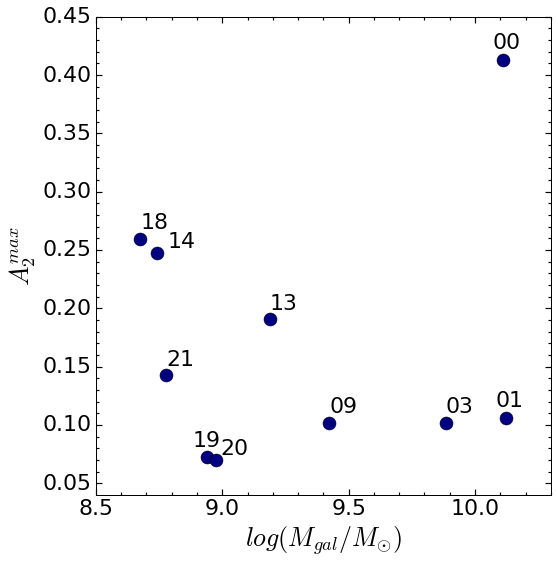

In [14]:
# Graficamos Mgal vs A2max
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot
import matplotlib.pyplot as plt

cm=np.loadtxt('/home/ornela/python/parametros.dat')

Mgal =cm[:,4]
A2max=cm[:,7]

vector = ('00','01','03','09','13','14','18','19','20','21')

fig=plt.figure(2, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax2=fig.add_subplot(111)
ax2.plot(Mgal,A2max,'o', markersize=13, color='navy')
ax2.set_xlim(8.5,10.3)
ax2.set_ylim(0.04,0.45)
ax2.minorticks_on()
ax2.tick_params( labelsize=22)
ax2.tick_params('both', length=3, width=1.2,which='minor')
ax2.tick_params('both', length=6, width=1.2,which='major')  
plt.xlabel(r'$log(M_{gal}/M_{\odot})$', fontsize=26)
plt.ylabel(r'$A_{2}^{max}$',fontsize=26)
for i in range(0,10):
    if vector[i] == '00':
        plt.annotate(str('%s'%vector[i]), xy=(Mgal[i],A2max[i]), 
                     xytext=(-10, +12), textcoords='offset points', fontsize=22)
    elif vector[i] == '01':
        plt.annotate(str('%s'%vector[i]), xy=(Mgal[i],A2max[i]), 
                     xytext=(-10, +12), textcoords='offset points', fontsize=22)
    elif vector[i] == '14':
        plt.annotate(str('%s'%vector[i]), xy=(Mgal[i],A2max[i]), 
                     xytext=(+10, +5), textcoords='offset points', fontsize=22)
    elif vector[i] == '19':
        plt.annotate(str('%s'%vector[i]), xy=(Mgal[i],A2max[i]), 
                     xytext=(-15, +10), textcoords='offset points', fontsize=22)
    elif vector[i] == '20':
        plt.annotate(str('%s'%vector[i]), xy=(Mgal[i],A2max[i]), 
                     xytext=(+5, +5), textcoords='offset points', fontsize=22)
    else:
        plt.annotate(str('%s'%vector[i]), xy=(Mgal[i],A2max[i]), 
                     xytext=(0, +10), textcoords='offset points', fontsize=22) 
    
fig.savefig('Mgal_vs_A2max.png', dpi = 80)
#plt.show()

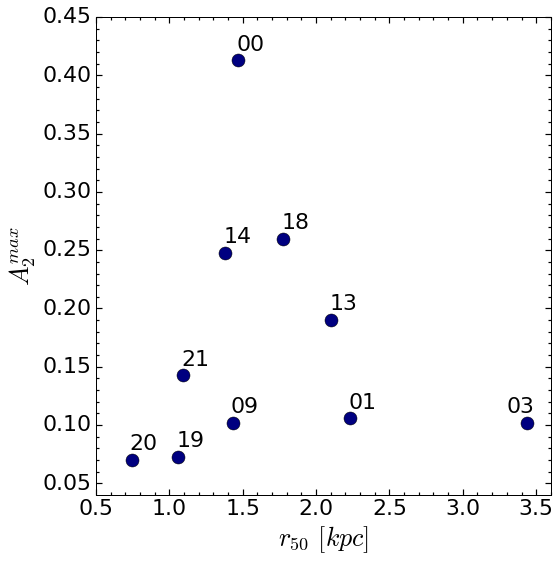

In [16]:
# Graficamos R50 vs A2max
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot
import matplotlib.pyplot as plt

cm=np.loadtxt('/home/ornela/python/parametros.dat')

r50  =cm[:,0]
A2max=cm[:,7]


vector = ('00','01','03','09','13','14','18','19','20','21')

fig=plt.figure(3, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax3=fig.add_subplot(111)
ax3.plot(r50,A2max,'o', markersize=13, color='navy')
ax3.set_xlim(0.5,3.6)
ax3.set_ylim(0.04,0.45)
ax3.minorticks_on()
ax3.tick_params( labelsize=22)
ax3.tick_params('both', length=3, width=1.2,which='minor')
ax3.tick_params('both', length=6, width=1.2,which='major')  
plt.xlabel(r'$r_{50}$ $[kpc]$', fontsize=26)
plt.ylabel(r'$A_{2}^{max}$',fontsize=26)
for i in range(0,10):
    if vector[i] == '03':
        plt.annotate(str('%s'%vector[i]), xy=(r50[i],A2max[i]), 
                     xytext=(-20, +10), textcoords='offset points', fontsize=22)
    else:
        plt.annotate('%s'% vector[i], xy=(r50[i],A2max[i]), 
                     xytext=(-2, +10), textcoords='offset points', fontsize=22)
fig.savefig('R50_vs_A2max.png', dpi = 80)
plt.show()

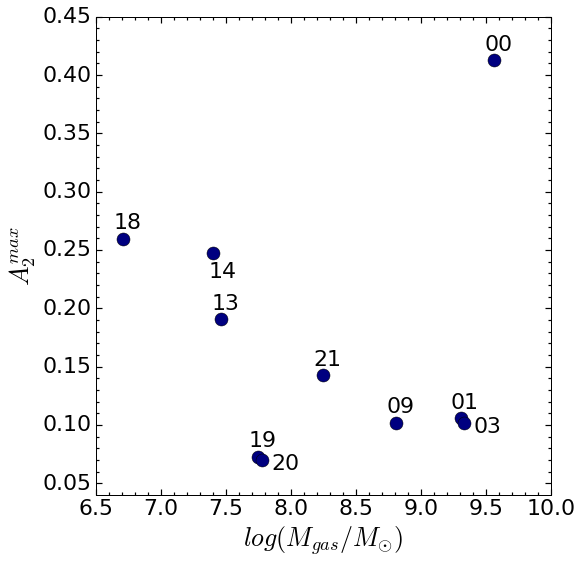

In [17]:
# Graficamos Mgas vs A2max
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot
import matplotlib.pyplot as plt

cm=np.loadtxt('/home/ornela/python/parametros.dat')

Mgas =cm[:,5]
A2max=cm[:,7]

vector = ('00','01','03','09','13','14','18','19','20','21')

fig=plt.figure(4, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax3=fig.add_subplot(111)
ax3.plot(Mgas,A2max,'o', markersize=13, color='navy')
ax3.set_ylim(0.04,0.45)
ax3.minorticks_on()
ax3.tick_params( labelsize=22)
ax3.tick_params('both', length=3, width=1.2,which='minor')
ax3.tick_params('both', length=6, width=1.2,which='major')  
ax3.set_xlabel(r'$log(M_{gas}/M_{\odot})$', fontsize=26)
ax3.set_ylabel(r'$A_{2}^{max}$',fontsize=26)
for i in range(0,10):
    if vector[i] == '03':
        plt.annotate('%s'% vector[i], xy=(Mgas[i],A2max[i]), 
                     xytext=(+10, -10), textcoords='offset points', fontsize=22)
    elif vector[i] == '14':
        plt.annotate('%s'% vector[i], xy=(Mgas[i],A2max[i]), 
                     xytext=(-5, -25), textcoords='offset points', fontsize=22)
    elif vector[i] == '20':
        plt.annotate('%s'% vector[i], xy=(Mgas[i],A2max[i]), 
                     xytext=(+10, -10), textcoords='offset points', fontsize=22)
    else:
        plt.annotate('%s'% vector[i], xy=(Mgas[i],A2max[i]), 
                     xytext=(-10, +10), textcoords='offset points', fontsize=22)
fig.savefig('Mgas_vs_A2max.png', dpi = 80)
#plt.show()

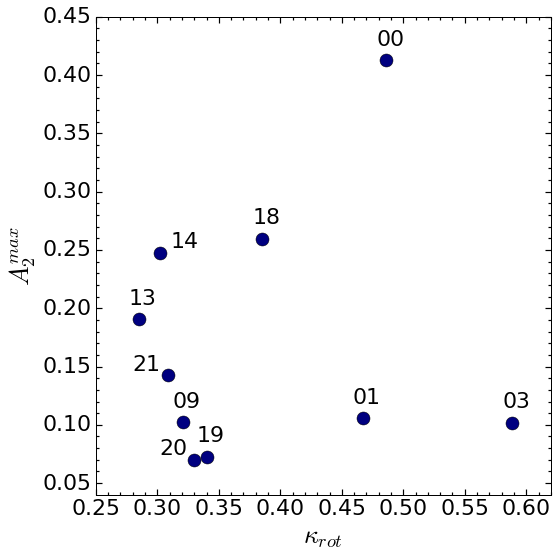

In [18]:
# Graficamos krot vs A2max
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot
import matplotlib.pyplot as plt

cm=np.loadtxt('/home/ornela/python/parametros.dat')

A2max=cm[:,7]
krot =cm[:,9]

vector = ('00','01','03','09','13','14','18','19','20','21')

fig=plt.figure(5, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax3=fig.add_subplot(111)
ax3.plot(krot,A2max,'o', markersize=13, color='navy')
ax3.set_ylim(0.04,0.45)
ax3.set_xlim(0.25,0.62)
ax3.minorticks_on()
ax3.tick_params( labelsize=22)
ax3.tick_params('both', length=3, width=1.2,which='minor')
ax3.tick_params('both', length=6, width=1.2,which='major')  
ax3.set_xlabel(r'$\kappa_{rot}$', fontsize=26)
ax3.set_ylabel(r'$A_{2}^{max}$',fontsize=26)
for i in range(0,10):
    if vector[i] == '14':
        plt.annotate('%s'% vector[i], xy=(krot[i],A2max[i]), 
                     xytext=(+10, +5), textcoords='offset points', fontsize=22)
    elif vector[i] == '20':
        plt.annotate('%s'% vector[i], xy=(krot[i],A2max[i]), 
                     xytext=(-35, +5), textcoords='offset points', fontsize=22)
    elif vector[i] == '21':
        plt.annotate('%s'% vector[i], xy=(krot[i],A2max[i]), 
                     xytext=(-35, +5), textcoords='offset points', fontsize=22)
    else:
        plt.annotate('%s'% vector[i], xy=(krot[i],A2max[i]), 
                     xytext=(-10, +15), textcoords='offset points', fontsize=22)
fig.savefig('krot_vs_A2max.png', dpi = 80)
#plt.show()


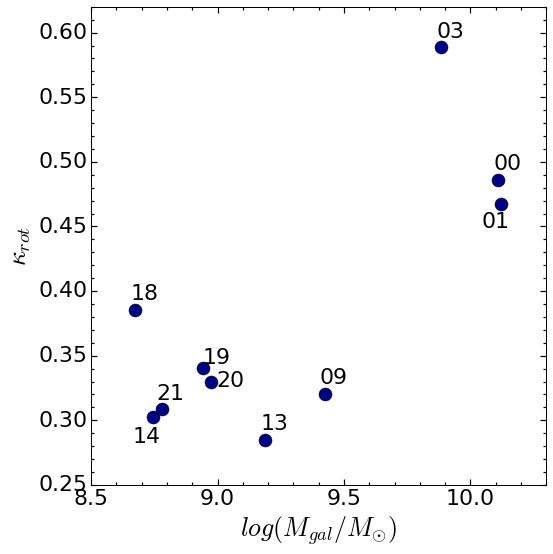

In [19]:
# Graficamos Mgal vs krot
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot
import matplotlib.pyplot as plt

cm=np.loadtxt('/home/ornela/python/parametros.dat')

Mgal =cm[:,4]
krot =cm[:,9]

vector = ('00','01','03','09','13','14','18','19','20','21')

fig=plt.figure(6, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax3=fig.add_subplot(111)
ax3.plot(Mgal,krot,'o', markersize=13, color='navy')
ax3.set_xlim(8.5,10.3)
ax3.set_ylim(0.25,0.62)
ax3.minorticks_on()
ax3.tick_params( labelsize=22)
ax3.tick_params('both', length=3, width=1.2,which='minor')
ax3.tick_params('both', length=6, width=1.2,which='major')  
ax3.set_xlabel(r'$log(M_{gal}/M_{\odot})$', fontsize=26)
ax3.set_ylabel(r'$\kappa_{rot}$',fontsize=26)
for i in range(0,10):
    if vector[i] == '14':
        plt.annotate('%s'% vector[i], xy=(Mgal[i],krot[i]), 
                     xytext=(-20, -25), textcoords='offset points', fontsize=22)
    elif vector[i] == '01':
        plt.annotate('%s'% vector[i], xy=(Mgal[i],krot[i]), 
                     xytext=(-20, -23), textcoords='offset points', fontsize=22)
    elif vector[i] == '20':
        plt.annotate('%s'% vector[i], xy=(Mgal[i],krot[i]), 
                     xytext=(+5, -5), textcoords='offset points', fontsize=22)
    elif vector[i] == '19':
        plt.annotate('%s'% vector[i], xy=(Mgal[i],krot[i]), 
                     xytext=(0, +5), textcoords='offset points', fontsize=22)
    else:
        plt.annotate('%s'% vector[i], xy=(Mgal[i],krot[i]), 
                     xytext=(-5, +10), textcoords='offset points', fontsize=22)
fig.savefig('Mgal_vs_krot.png', dpi = 80)

In [15]:
#PARA SABER LA MASA DE LAS PARTICULAS 
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot

import matplotlib.pyplot as plt
import h5py
import rotation as rot
import barstrength as strng
import kapparot as krot

#fo=open('/home/ornela/python/parametros.dat','w')
h = 0.732

vector = ('00','01','03','09','13','14','18','19','20','21')

snapshot=range(497,496,-1)
for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
    for i in range(0,1):
        pstr = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
        cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
        vel  = snap['subhalo_0'+ str('%s' %vector[i])+ '/Str/Velocities'].value
        masa_str = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value
        
        pgas = snap['subhalo_0'+ str('%s' %vector[i])+ '/Gas/Coordinates'].value
        masa_gas = snap['subhalo_0'+ str('%s' %vector[i])+ '/Gas/Masses'].value
        
        pdrk = snap['subhalo_0'+ str('%s' %vector[i]) + '/Drk/Coordinates'].value
        masa_drk = snap['subhalo_0'+ str('%s' %vector[i])+ '/Drk/Masses'].value
        
#---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])/h
        ystr = (pstr[:,1]-cm[1])/h
        zstr = (pstr[:,2]-cm[2])/h
        r = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xgas = (pgas[:,0]-cm[0])/h
        ygas = (pgas[:,1]-cm[1])/h
        zgas = (pgas[:,2]-cm[2])/h
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)
        
        xdrk = (pdrk[:,0]-cm[0])/h
        ydrk = (pdrk[:,1]-cm[1])/h
        zdrk = (pdrk[:,2]-cm[2])/h
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
        
#----------------------masas----------------------------
        #masa_str = masa_str/h
        #masa_gas = masa_gas/h
        #masa_drk = masa_drk/h
        
        print masa_str

[  2.21282744e-06   2.21282744e-06   2.21282744e-06 ...,   2.21282744e-06
   2.21282744e-06   2.21282744e-06]
